# Table of Contents
- [Import Libraries](#Import-Libraries)

- [Obtain Data](#Obtain-Data)
    - [Import data](#Import-data)
- [Scrub Data](#Scrub-Data)
- [EDA](#EDA)
- [Modeling](#Modeling)

# Import Libraries

In [539]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import datetime
from shapely.geometry import Point, Polygon, MultiPolygon
import geopandas as gpd
from opencage.geocoder import OpenCageGeocode, InvalidInputError, RateLimitExceededError, UnknownError
from pprint import pprint
import json
import requests
import time

[Return to contents](#Table-of-Contents)

# Functions

In [572]:
def clean_df(df):
    # drop columns that are not needed
    new_df = df.drop(['Location 1', 'vri_name1', 'Total Incidents'], axis=1)
    
    # Change 'outside' or 'inside' to 'O' and 'I'
    new_df['Inside/Outside'].replace(to_replace='Outside', value='O', inplace=True)
    new_df['Inside/Outside'].replace(to_replace='Inside', value='I', inplace=True)
    
    # Fill null values for Weapon with placeholder value of 'none'
    new_df['Weapon'].fillna(value='none', axis=0, inplace=True)
    
    # Fill null values for Premise with placeholder value of 'UNKNOWN'
    new_df['Premise'].fillna(value='UNKNOWN', axis=0, inplace=True)
    
    # Fill null values for Post with placeholder value of 'UNKNOWN'
    new_df['Post'].fillna(value='UNKNOWN', axis=0, inplace=True)
    
    # Drop rows that do not have CrimeTime as there are only 23 and there is no way to figure out the time
    new_df.dropna(subset=['CrimeTime'], axis = 0, inplace=True)
    
    # Fill longitude and latitude where there is a neighborhood mentioned
    no_long_lat_with_neighborhood = new_df[(new_df['Longitude'].isna()) & (new_df['Neighborhood'].notnull())]
    get_lat_long_from_neighborhood(no_long_lat_with_neighborhood, new_df)
    
    # Fill longitude and latitude where there is a location mentioned
    no_long_lat_with_location = new_df[new_df['Longitude'].isna() & new_df['Neighborhood'].isna() & new_df['Location'].notnull()]
    get_lat_long_from_location(no_long_lat_with_location, new_df, key)
    
    # Fill location as 'Unknown' where there is a longitude and latitude
    fill_location_as_unknown(new_df)
    
    # Drop rows where is no location, neighborhood and long/lat
    no_location_index_to_drop = new_df[(new_df['Longitude'].isna()) & (new_df['Neighborhood'].isna()) & (new_df['Location'].isna())].index
    new_df.drop(no_location_index_to_drop, axis=0, inplace=True)
    
    # Fill null values for neighborhoods based on long/lat and fix the neighborhoods to all display names as they are in the shapefile
    neighborhood_shapes = gpd.read_file('Neighborhoods/geo_export_273e8db1-4514-4c9c-ba6d-6e584e4d2023.shp')
    # Fix one neighborhood name that is all upper to be in title format
    neighborhood_shapes.at[272, 'label'] = neighborhood_shapes[neighborhood_shapes['label'] == 'CARE'].label.str.title()
    fill_and_fix_neighborhoods(new_df, neighborhood_shapes)
    
    # Fill in Inside/Outside based on how often a crime is done inside or outside
    fill_inside_outside_from_crime_percentage(new_df)
    
    # Drop any rows that still have null values
    new_df.dropna(axis=0, inplace=True)
    
    # Drop all rows that still have a neighborhood name that is all upper, as they would only be that way if their lat/long is outside the shapefile
    index_to_drop = new_df[new_df.Neighborhood.str.isupper()].index
    new_df.drop(index_to_drop, axis= 0, inplace=True)
    
    return new_df

def get_lat_long_from_location(filtered_df, df, key):
    geocoder = OpenCageGeocode(key)
    for index, row in filtered_df.iterrows():
        address = row['Location']
        query = f'{address}, Baltimore, MD'
        results = geocoder.geocode(query)
        df.at[index, 'Latitude'] = results[0]['geometry']['lat']
        df.at[index, 'Longitude'] = results[0]['geometry']['lng']
    
    pass
        
        
def get_lat_long_from_neighborhood(filtered_df, df):
    temp_df = pd.DataFrame()

    for neighborhood in df.Neighborhood.unique():
        try:
            temp_df = temp_df.append(df[(df.Neighborhood == neighborhood) & (df.Longitude.notnull())].iloc[0, :])
        except:
            continue
    
    for index, row in filtered_df.iterrows():
        row_neighborhood = row.Neighborhood
        df.at[index, 'Latitude'] = temp_df[temp_df['Neighborhood'] == row_neighborhood]['Latitude']
        df.at[index, 'Longitude'] = temp_df[temp_df['Neighborhood'] == row_neighborhood]['Longitude']
    
    pass

def fill_location_as_unknown(df):
    rows_to_change = df[(df.Location.isna()) & (df.Longitude.notnull())]
    for index, row in rows_to_change.iterrows():
        df.at[index, 'Location'] = 'Unknown'
    pass


def fill_and_fix_neighborhoods(df, shapesdf):
    
    for index2, row2 in df.iterrows():
        Point1 = Point(row2['Longitude'], row2['Latitude'])
    
        for index, row in shapesdf.iterrows():
            try:
                Polygon1 = Polygon(row.geometry)
            except:
                Polygon1 = MultiPolygon(row.geometry)

            if Point1.within(Polygon1) == True:
                df.at[index2, 'Neighborhood'] = row.label
                break
    pass

def fill_inside_outside_from_crime_percentage(df):
    
    # Slice the df for only the null values
    inout = df[df['Inside/Outside'].isna()]
    
    # Get the crimes to be changed based on percentages
    crime_to_slice = []
    
    # Get all crimes to be changed to inside
    crime_to_slice_inside = []
    
    # Get all crimes to be changed to outside
    crime_to_slice_outside = []
    
    for crime in df.Description.unique():
        try:
            inside = df.loc[(df['Inside/Outside'] == 'I')].Description.value_counts()[crime]
        except:
            continue
        try:
            outside = df.loc[(df['Inside/Outside'] == 'O')].Description.value_counts()[crime]
        except:
            continue

        if round(inside/(inside+outside), 2) > .5:
            crime_to_slice_inside.append(crime)

            if round(inside/(inside+outside), 2) > .3 and round(outside/(inside+outside), 2) > .3:
                crime_to_slice.append(crime)

        elif round(outside/(inside+outside), 2) > .5:
            crime_to_slice_outside.append(crime)

            if round(inside/(inside+outside), 2) > .3 and round(outside/(inside+outside), 2) > .3:
                crime_to_slice.append(crime)
    
    # Make a df with the inside percentage so we can use it to change the respective crimes to inside or outside based on it
    crime_neighborhoods = {}
    crimes = {}
    inside_percentage = {}

    for crime in crime_to_slice:
        for neighborhood in df.Neighborhood.unique():
            try:
                inside = df.loc[(df['Neighborhood'] == neighborhood) & (df['Inside/Outside'] == 'I')].Description.value_counts()[crime]
            except:
                inside = 0

            try:
                outside = df.loc[(df['Neighborhood'] == neighborhood) & (df['Inside/Outside'] == 'O')].Description.value_counts()[crime]
            except:
                outside = 0

            if inside == 0 and outside == 0:
                continue

            try:
                crime_neighborhoods[f'{crime},{neighborhood}'] = neighborhood
                crimes[f'{crime},{neighborhood}'] = crime
                inside_percentage[f'{crime},{neighborhood}'] = round(inside/(inside+outside), 2)

            except:
                continue

    crime_neighborhood_df = pd.DataFrame()
    crime_neighborhood_df['neighborhood'] = crime_neighborhoods.values()
    crime_neighborhood_df['crime'] = crimes.values()
    crime_neighborhood_df['inside_percentage'] = inside_percentage.values()
    
    # Change the Inside/Outside nulls based on the above information
    
    for crime in inout.Description.unique():

        if crime in crime_to_slice:

            crime_to_fill = inout.loc[inout['Description'] == crime]
            for neighborhood in crime_to_fill.Neighborhood.unique():
                indices_to_change = crime_to_fill.loc[crime_to_fill['Neighborhood'] == neighborhood].index.tolist()
                np.random.shuffle(indices_to_change)


                inside_percentage = crime_neighborhood_df.loc[(crime_neighborhood_df['neighborhood'] == neighborhood) & (crime_neighborhood_df['crime'] == crime)]['inside_percentage']

                try:
                    inside_amount = int(inside_percentage*len(indices_to_change))

                except:
                    if crime in crime_to_slice_inside:
                        for index in indices_to_change:
                            df.at[index, 'Inside/Outside'] = 'I'
                    elif crime in crime_to_slice_outside:
                        for index in indices_to_change:
                            df.at[index, 'Inside/Outside'] = 'O'
                    continue

                for index in indices_to_change[:inside_amount]:
                    df.at[index, 'Inside/Outside'] = 'I'

                for index in indices_to_change[inside_amount:]:
                    df.at[index, 'Inside/Outside'] = 'O'

        elif crime in crime_to_slice_inside:
            crime_to_fill = inout.loc[inout['Description'] == crime]
            indices_to_change = crime_to_fill.index.tolist()
            for index in indices_to_change:
                df.at[index, 'Inside/Outside'] = 'I'

        elif crime in crime_to_slice_outside:
            crime_to_fill = inout.loc[inout['Description'] == crime]
            indices_to_change = crime_to_fill.index.tolist()
            for index in indices_to_change:
                df.at[index, 'Inside/Outside'] = 'O'

[Return to contents](#Table-of-Contents)

# Obtain Data

## Import data

In [3]:
df = pd.read_csv('BPD_Part_1_Victim_Based_Crime_Data.csv')
df.head()

,CrimeDate,CrimeTime,CrimeCode,Location,Description,Inside/Outside,Weapon,Post,District,Neighborhood,Longitude,Latitude,Location 1,Premise,vri_name1,Total Incidents
0,09/07/2019,08:53:00,4E,1000 N MOUNT ST,COMMON ASSAULT,I,NaN,743.0,WESTERN,SANDTOWN-WINCHESTER,-76.644485,39.300357,NaN,ROW/TOWNHOUSE-OCC,NaN,1
1,09/07/2019,16:29:00,4D,300 PARK AVE,AGG. ASSAULT,O,HANDS,111.0,CENTRAL,DOWNTOWN,-76.618155,39.292978,NaN,STREET,NaN,1
2,09/07/2019,23:22:33,9S,2900 JEFFERSON ST,SHOOTING,Outside,FIREARM,224.0,SOUTHEAST,MILTON-MONTFORD,-76.576075,39.297009,NaN,STREET,NaN,1
3,09/07/2019,22:59:00,7A,1100 N PATTERSON PARK AVE,AUTO THEFT,O,NaN,322.0,EASTERN,MIDDLE EAST,-76.585487,39.303928,NaN,STREET,Eastern 2,1
4,09/07/2019,00:15:00,6G,100 ALLENDALE ST,LARCENY,I,NaN,843.0,SOUTHWEST,ALLENDALE,-76.678216,39.290278,NaN,ROW/TOWNHOUSE-OCC,NaN,1


Check size of df

In [4]:
df.shape

(274187, 16)

[Return to contents](#Table-of-Contents)

# Scrub Data

**Checkout Null values**

In [5]:
df.isna().sum()

CrimeDate               0
CrimeTime              23
CrimeCode               0
Location             1162
Description             0
Inside/Outside      29856
Weapon             216774
Post                 1556
District                0
Neighborhood        10383
Longitude            1497
Latitude             1497
Location 1         274187
Premise             30109
vri_name1          241758
Total Incidents         0
dtype: int64

There are a bunch of null values to figure out what to do with 

**General info**

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 274187 entries, 0 to 274186
Data columns (total 16 columns):
CrimeDate          274187 non-null object
CrimeTime          274164 non-null object
CrimeCode          274187 non-null object
Location           273025 non-null object
Description        274187 non-null object
Inside/Outside     244331 non-null object
Weapon             57413 non-null object
Post               272631 non-null float64
District           274187 non-null object
Neighborhood       263804 non-null object
Longitude          272690 non-null float64
Latitude           272690 non-null float64
Location 1         0 non-null float64
Premise            244078 non-null object
vri_name1          32429 non-null object
Total Incidents    274187 non-null int64
dtypes: float64(4), int64(1), object(11)
memory usage: 33.5+ MB


**Check unique values to see if there are any placeholders**

In [7]:
for col in df.columns:
    print(f'\n\n{col}\n')
    print(df[col].value_counts())
    print(df[col].unique())    



CrimeDate

04/27/2015    421
06/05/2016    255
12/20/2018    209
01/20/2017    205
10/25/2017    202
             ... 
11/09/2009      1
09/17/2008      1
01/01/1985      1
07/01/1980      1
01/14/2007      1
Name: CrimeDate, Length: 2141, dtype: int64
['09/07/2019' '09/06/2019' '09/05/2019' ... '05/01/1977' '07/20/1969'
 '10/30/1963']


CrimeTime

18:00:00    6360
17:00:00    6086
12:00:00    5680
16:00:00    5608
20:00:00    5535
            ... 
19:29:37       1
23:09:40       1
20:53:29       1
06:21:40       1
03:15:41       1
Name: CrimeTime, Length: 1486, dtype: int64
['08:53:00' '16:29:00' '23:22:33' ... '22:26:39' '13:38:52' '01:52:27']


CrimeCode

4E     44708
6D     36628
5A     24131
7A     22987
6J     14995
       ...  
8FV        4
8I         4
8CV        3
8DO        2
3N         1
Name: CrimeCode, Length: 81, dtype: int64
['4E' '4D' '9S' '7A' '6G' '6D' '6C' '3AF' '6J' '3AK' '6E' '4B' '5A' '1A'
 '4C' '3CF' '6A' '3B' '7C' '5C' '3AJF' '4A' '3K' '5D' '5G' '6F' '2A' '3P'

[-76.6444851  -76.618155   -76.57607482 ... -76.665086   -76.60130091
 -76.626872  ]


Latitude

39.274088    614
39.318689    504
39.298841    484
39.317532    381
39.287617    363
            ... 
39.352792      1
39.294835      1
39.327806      1
39.303038      1
39.307040      1
Name: Latitude, Length: 88268, dtype: int64
[39.30035681 39.292978   39.29700864 ... 39.298065   39.33846787
 39.328777  ]


Location 1

Series([], Name: Location 1, dtype: int64)
[nan]


Premise

STREET                  98809
ROW/TOWNHOUSE-OCC       51041
APT/CONDO - OCCUPIED    10942
OTHER - INSIDE          10172
PARKING LOT-OUTSIDE     10139
                        ...  
SHED                        3
MOBILE HOME                 3
CHURCH                      2
BOX CARS/COMM'L TRLR        2
TRUCKING & TRANSFER         2
Name: Premise, Length: 125, dtype: int64
['ROW/TOWNHOUSE-OCC' 'STREET' 'PARKING LOT-OUTSIDE' 'GROCERY/CONFECTION'
 'ALLEY' nan 'RETAIL/SMALL BUSINES' 'APT/CONDO - OCCUPIED'
 'OTHER - INSIDE

**Some initial thoughts on this information**

CrimeDate - No Null values and seems to be no filler values  
CrimeTime - 23 Null values, there do not seem to be any filler values  
CrimeCode - No Null values and seems to be no filler values  
Location - 1162 Null values, I wonder if there is crossover with the null lat and long. Will need to check into this further  
Description - No Null values and seems to be no filler values  
Inside/Outside - 29856 Null values, can fill based on crime, if most occur inside or out. Also need to change any that say 'outside' or 'inside' to 'O' or 'I'  
Weapon - 216774 Null, most crimes do not have a weapon. I think I will fill them with 'None' so it is not null but shows there were no weapons in that crime  
Post - 1556 Null values, Will need to decide how to handle these. Seems to be no placeholders  
District - No Nulls, but there are 125 UNKNOWN which I will need to descide what to do with  
Neighborhood - 10383 Nulls, would like to fill in by checking with lat and long which neighborhood they are in.   
    Baltimore does have 278 neighborhoods, however none of them are named CONCERNED CITIZENS O, though that may refer to Concerned Citizens of Forest Park (CCOFP).   
    Four by Four is a neighborhood that is written here as 4X4  
116102 and 000 seem to be placeholders that I will need to figure out where those crimes should be located  
Longitude - 1497 Null values, seems to be no placeholders  
Latitude - 1497 Null values, seems to be no placeholders  
Location 1 - All Null values, will just drop the column  
Premise - 30109 Null values, and 969 UNKNOWN. May just fill with the same placeholder, UNKNOWN  
vri_name1 - 241758 Null values, will drop the column as that is most of the dataset  
Total Incidents - All values are 1, so will drop this column as well

**Figure out how to replace Inside/Outside nulls**

In [8]:
df[df['Inside/Outside'].isna()].Description.value_counts()

LARCENY                 7407
LARCENY FROM AUTO       5419
COMMON ASSAULT          4968
AGG. ASSAULT            3436
BURGLARY                3344
AUTO THEFT              1930
ROBBERY - STREET        1832
ROBBERY - COMMERCIAL     549
ROBBERY - CARJACKING     309
RAPE                     279
ROBBERY - RESIDENCE      269
ARSON                    114
Name: Description, dtype: int64

In [516]:
crime_to_slice = []
crime_percentage = {}
for crime in df.Description.unique():
    inside = df.loc[(df['Inside/Outside'] == 'I') | (df['Inside/Outside'] == 'Inside')].Description.value_counts()[crime]
    outside = df.loc[(df['Inside/Outside'] == 'O') | (df['Inside/Outside'] == 'Outside')].Description.value_counts()[crime]
    if round(inside/(inside+outside), 2) > .3 and round(outside/(inside+outside), 2) > .3:
        print(f'\n{crime}\nInside: {inside} %{round(inside/(inside+outside), 2)}\nOutside: {outside} %{round(outside/(inside+outside), 2)}')
        print(df[df['Inside/Outside'].isna()].Description.value_counts()[crime])
        crime_percentage[crime] = round(inside/(inside+outside), 2)
        crime_to_slice.append(crime)


COMMON ASSAULT
Inside: 26019 %0.65
Outside: 13721 %0.35
4968

AGG. ASSAULT
Inside: 12427 %0.48
Outside: 13665 %0.52
3436

LARCENY
Inside: 30898 %0.57
Outside: 22887 %0.43
7407

ARSON
Inside: 537 %0.48
Outside: 576 %0.52
114


In [466]:
crime_inside = []
crime_outside = []
for crime in df.Description.unique():
    if crime in crime_to_slice:
        continue
    inside = df.loc[(df['Inside/Outside'] == 'I') | (df['Inside/Outside'] == 'Inside')].Description.value_counts()[crime]
    outside = df.loc[(df['Inside/Outside'] == 'O') | (df['Inside/Outside'] == 'Outside')].Description.value_counts()[crime]
    if round(inside/(inside+outside), 2) > .5:
        crime_inside.append(crime)
        print(f'{crime}: Inside: {round(inside/(inside+outside), 2)}')
        
    elif round(outside/(inside+outside), 2) > .5:
        crime_outside.append(crime)
        print(f'{crime}: Outside: {round(outside/(inside+outside), 2)}')

SHOOTING: Outside: 0.92
AUTO THEFT: Outside: 0.92
LARCENY FROM AUTO: Outside: 0.93
ROBBERY - STREET: Outside: 0.91
BURGLARY: Inside: 0.95
HOMICIDE: Outside: 0.82
ROBBERY - COMMERCIAL: Inside: 0.87
ROBBERY - CARJACKING: Outside: 0.96
ROBBERY - RESIDENCE: Inside: 0.97
RAPE: Inside: 0.74


In [10]:
4968/(26019+13721+4968)

0.11112105216068713

In [11]:
3436/(12427+13665+3436)

0.11636412896234083

In [12]:
7407/(30898+22887+7407)

0.12104523467119885

In [374]:
crime_percentage, crime_to_slice

({'COMMON ASSAULT': 0.65,
  'AGG. ASSAULT': 0.48,
  'LARCENY': 0.57,
  'ARSON': 0.48},
 ['COMMON ASSAULT', 'AGG. ASSAULT', 'LARCENY', 'ARSON'])

In [502]:
crime_to_slice_inside = ['COMMON ASSAULT', 'LARCENY']
crime_to_slice_outside = ['AGG. ASSAULT', 'ARSON']

In [489]:
inout = df[df['Inside/Outside'].isna()].dropna(subset=['Neighborhood'], axis=0)
inout.head()

,CrimeDate,CrimeTime,CrimeCode,Location,Description,Inside/Outside,Weapon,Post,District,Neighborhood,Longitude,Latitude,Location 1,Premise,vri_name1,Total Incidents
14,09/07/2019,15:50:00,4E,600 CHERRY HILL RD,COMMON ASSAULT,NaN,NaN,922.0,SOUTHERN,CHERRY HILL,-76.622350,39.250288,NaN,NaN,NaN,1
15,09/07/2019,15:00:00,4E,2500 W PATAPSCO AVE,COMMON ASSAULT,NaN,NaN,923.0,SOUTHERN,LAKELAND,-76.651314,39.252504,NaN,NaN,NaN,1
16,09/07/2019,15:30:00,4E,5000 CATALPHA RD,COMMON ASSAULT,NaN,NaN,421.0,NORTHEAST,LAURAVILLE,-76.571026,39.350152,NaN,NaN,NaN,1
17,09/07/2019,15:56:00,6J,6100 PARKWAY DR,LARCENY,NaN,NaN,522.0,NORTHERN,LAKE WALKER,-76.601324,39.369251,NaN,NaN,NaN,1
18,09/07/2019,17:40:00,6J,5200 YORK RD,LARCENY,NaN,NaN,521.0,NORTHERN,LOYOLA/NOTRE DAME,-76.609860,39.353566,NaN,NaN,NaN,1


In [15]:
for crime in inout.Description.unique():
    inside = df.loc[(df['Inside/Outside'] == 'I') | (df['Inside/Outside'] == 'Inside')].Description.value_counts()[crime]
    outside = df.loc[(df['Inside/Outside'] == 'O') | (df['Inside/Outside'] == 'Outside')].Description.value_counts()[crime]
    
    if crime in crime_to_slice:
        p = int(len(inout.loc[inout['Description'] == crime]) * crime_percentage[crime])
        print(p)
        display(inout.loc[inout['Description'] == crime][:p].fillna(value='I', axis=0, inplace=True))
        inout.loc[inout['Description'] == crime][p:].fillna(value='O', axis=0, inplace=True)
        
    else:
        continue
        display(df.loc[df['Description'] == crime].fillna(value='O', axis=0))

3229


None

4221


None

1649


None

54


None

206


None

In [377]:
inout.loc[inout['Description'] == 'COMMON ASSAULT']['Inside/Outside'][:3229].fillna(value='I', axis=0, inplace=True)

In [422]:
indices_to_change = inout.loc[inout['Description'] == 'COMMON ASSAULT'].index.tolist()

In [425]:
indices_to_change[:10]

[110129, 126131, 7651, 104161, 107408, 56591, 72887, 57816, 27222, 80458]

In [424]:
np.random.shuffle(indices_to_change)

In [18]:
inout[inout['Inside/Outside'].isna()].Description.value_counts()

LARCENY                 7407
LARCENY FROM AUTO       5419
COMMON ASSAULT          4968
AGG. ASSAULT            3436
BURGLARY                3344
AUTO THEFT              1930
ROBBERY - STREET        1832
ROBBERY - COMMERCIAL     549
ROBBERY - CARJACKING     309
RAPE                     279
ROBBERY - RESIDENCE      269
ARSON                    114
Name: Description, dtype: int64

In [19]:
len(df['Inside/Outside'].dropna())

244331

In [458]:
crime_neighborhoods = {}
crimes = {}
inside_percentage = {}

for crime in crime_to_slice:
    for neighborhood in df.Neighborhood.unique():
        try:
            inside = df.loc[(df['Neighborhood'] == neighborhood) & ((df['Inside/Outside'] == 'I') | (df['Inside/Outside'] == 'Inside'))].Description.value_counts()[crime]
        except:
            inside = 0
        
        try:
            outside = df.loc[(df['Neighborhood'] == neighborhood) & ((df['Inside/Outside'] == 'O') | (df['Inside/Outside'] == 'Outside'))].Description.value_counts()[crime]
        except:
            outside = 0
        
        if inside == 0 and outside == 0:
            continue
            
        try:
            crime_neighborhoods[f'{crime},{neighborhood}'] = neighborhood
            crimes[f'{crime},{neighborhood}'] = crime
            inside_percentage[f'{crime},{neighborhood}'] = round(inside/(inside+outside), 2)
            
        except:
            continue

In [459]:
len(crime_neighborhoods), len(crimes), len(inside_percentage), len(outside_percentage), len(crime_total)

(1021, 1021, 1021, 1021, 1021)

In [460]:
crime_neighborhood_df = pd.DataFrame()
crime_neighborhood_df['neighborhood'] = crime_neighborhoods.values()
crime_neighborhood_df['crime'] = crimes.values()
crime_neighborhood_df['inside_percentage'] = inside_percentage.values()
crime_neighborhood_df['outside_percentage'] = outside_percentage.values()
crime_neighborhood_df['crime_total'] = crime_total.values()

In [461]:
crime_neighborhood_df.head()

,neighborhood,crime,inside_percentage,outside_percentage,crime_total
0,SANDTOWN-WINCHESTER,COMMON ASSAULT,0.67,0.33,741
1,DOWNTOWN,COMMON ASSAULT,0.44,0.56,1467
2,MILTON-MONTFORD,COMMON ASSAULT,0.56,0.44,158
3,MIDDLE EAST,COMMON ASSAULT,0.62,0.38,303
4,ALLENDALE,COMMON ASSAULT,0.79,0.21,247


In [487]:
crime_neighborhood_df.inside_percentage.value_counts()

0.00    60
0.50    53
1.00    51
0.67    32
0.53    28
        ..
0.09     1
0.10     1
0.19     1
0.92     1
0.91     1
Name: inside_percentage, Length: 81, dtype: int64

In [527]:
for crime in inout.Description.unique():

    if crime in crime_to_slice:
        
        crime_to_fill = inout.loc[inout['Description'] == crime]
        for neighborhood in crime_to_fill.Neighborhood.unique():
            indices_to_change = crime_to_fill.loc[crime_to_fill['Neighborhood'] == neighborhood].index.tolist()
            np.random.shuffle(indices_to_change)
            

            inside_percentage = crime_neighborhood_df.loc[(crime_neighborhood_df['neighborhood'] == neighborhood) & (crime_neighborhood_df['crime'] == crime)]['inside_percentage']
            
            try:
                inside_amount = int(inside_percentage*len(indices_to_change))
            
            except:
                if crime in crime_to_slice_inside:
                    for index in indices_to_change:
                        inout.at[index, 'Inside/Outside'] = 'I'
                elif crime in crime_to_slice_outside:
                    for index in indices_to_change:
                        inout.at[index, 'Inside/Outside'] = 'O'
                continue
            
            for index in indices_to_change[:inside_amount]:
                inout.at[index, 'Inside/Outside'] = 'I'
                
            for index in indices_to_change[inside_amount:]:
                inout.at[index, 'Inside/Outside'] = 'O'
                
    elif crime in crime_to_slice_inside:
        crime_to_fill = inout.loc[inout['Description'] == crime]
        indices_to_change = crime_to_fill.index.tolist()
        for index in indices_to_change:
            inout.at[index, 'Inside/Outside'] = 'I'
    
    elif crime in crime_to_slice_outside:
        crime_to_fill = inout.loc[inout['Description'] == crime]
        indices_to_change = crime_to_fill.index.tolist()
        for index in indices_to_change:
            inout.at[index, 'Inside/Outside'] = 'O'

In [528]:
inout[inout['Inside/Outside'].isna()].Description.unique()

array([], dtype=object)

In [534]:
inout.loc[inout['Description'] == 'LARCENY']

,CrimeDate,CrimeTime,CrimeCode,Location,Description,Inside/Outside,Weapon,Post,District,Neighborhood,Longitude,Latitude,Location 1,Premise,vri_name1,Total Incidents
17,09/07/2019,15:56:00,6J,6100 PARKWAY DR,LARCENY,I,NaN,522.0,NORTHERN,LAKE WALKER,-76.601324,39.369251,NaN,NaN,NaN,1
18,09/07/2019,17:40:00,6J,5200 YORK RD,LARCENY,I,NaN,521.0,NORTHERN,LOYOLA/NOTRE DAME,-76.609860,39.353566,NaN,NaN,NaN,1
50,09/06/2019,23:20:00,6C,0 LIGHT ST,LARCENY,O,NaN,111.0,CENTRAL,DOWNTOWN,-76.613687,39.288015,NaN,NaN,NaN,1
100,09/06/2019,11:42:00,6J,3500 ERDMAN AVE,LARCENY,O,NaN,434.0,NORTHEAST,BELAIR-EDISON,-76.570408,39.318285,NaN,NaN,NaN,1
101,09/06/2019,13:10:00,6J,4200 SHAMROCK AVE,LARCENY,O,NaN,442.0,NORTHEAST,BELAIR-EDISON,-76.565235,39.328119,NaN,NaN,Northeastern,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
273527,01/06/2014,18:25:00,6G,1400 N CHARLES ST,LARCENY,I,NaN,141.0,CENTRAL,MID-TOWN BELVEDERE,-76.616300,39.306444,NaN,NaN,NaN,1
273623,01/05/2014,14:15:00,6J,1400 HOMESTEAD ST,LARCENY,O,NaN,411.0,NORTHEAST,COLDSTREAM HOMESTEAD,-76.598934,39.322968,NaN,NaN,NaN,1
273945,01/02/2014,18:45:00,6G,600 President Street,LARCENY,I,NaN,211.0,SOUTHEAST,INNER HARBOR,-76.601699,39.283596,NaN,NaN,NaN,1
274089,01/01/2014,01:00:00,6J,0 MARKET PL,LARCENY,I,NaN,111.0,CENTRAL,DOWNTOWN,-76.606697,39.289410,NaN,NaN,NaN,1


In [505]:
inout.loc[inout['Inside/Outside'].isna()]

,CrimeDate,CrimeTime,CrimeCode,Location,Description,Inside/Outside,Weapon,Post,District,Neighborhood,Longitude,Latitude,Location 1,Premise,vri_name1,Total Incidents


In [518]:
inout.loc[(inout['Inside/Outside'] == 'I') | (df['Inside/Outside'] == 'Inside')].Description.value_counts()

LARCENY                 4041
BURGLARY                3264
COMMON ASSAULT          3024
AGG. ASSAULT            1475
ROBBERY - COMMERCIAL     537
RAPE                     262
ROBBERY - RESIDENCE      262
ARSON                     23
Name: Description, dtype: int64

In [524]:
inout.Description.unique()

array(['COMMON ASSAULT', 'LARCENY', 'AGG. ASSAULT', 'ROBBERY - STREET',
       'ROBBERY - RESIDENCE', 'BURGLARY', 'LARCENY FROM AUTO',
       'AUTO THEFT', 'ARSON', 'ROBBERY - CARJACKING',
       'ROBBERY - COMMERCIAL', 'RAPE'], dtype=object)

In [525]:
crime_to_slice = []
crime_to_slice_inside = []
crime_to_slice_outside = []

for crime in df.Description.unique():
    try:
        inside = df.loc[(df['Inside/Outside'] == 'I') | (df['Inside/Outside'] == 'Inside')].Description.value_counts()[crime]
    except:
        continue
    try:
        outside = df.loc[(df['Inside/Outside'] == 'O') | (df['Inside/Outside'] == 'Outside')].Description.value_counts()[crime]
    except:
        continue
    
    if round(inside/(inside+outside), 2) > .5:
        crime_to_slice_inside.append(crime)
        
        if round(inside/(inside+outside), 2) > .3 and round(outside/(inside+outside), 2) > .3:
            crime_to_slice.append(crime)
        
    elif round(outside/(inside+outside), 2) > .5:
        crime_to_slice_outside.append(crime)
        
        if round(inside/(inside+outside), 2) > .3 and round(outside/(inside+outside), 2) > .3:
            crime_to_slice.append(crime)



In [526]:
crime_to_slice, crime_to_slice_inside, crime_to_slice_outside

(['COMMON ASSAULT', 'AGG. ASSAULT', 'LARCENY', 'ARSON'],
 ['COMMON ASSAULT',
  'LARCENY',
  'BURGLARY',
  'ROBBERY - COMMERCIAL',
  'ROBBERY - RESIDENCE',
  'RAPE'],
 ['AGG. ASSAULT',
  'SHOOTING',
  'AUTO THEFT',
  'LARCENY FROM AUTO',
  'ROBBERY - STREET',
  'HOMICIDE',
  'ROBBERY - CARJACKING',
  'ARSON'])

In [535]:
def fill_inside_outside_from_crime_percentage(df):
    
    # Slice the df for only the null values
    inout = df[df['Inside/Outside'].isna()]
    
    # Get the crimes to be changed based on percentages
    crime_to_slice = []
    
    # Get all crimes to be changed to inside
    crime_to_slice_inside = []
    
    # Get all crimes to be changed to outside
    crime_to_slice_outside = []
    
    for crime in df.Description.unique():
        try:
            inside = df.loc[(df['Inside/Outside'] == 'I')].Description.value_counts()[crime]
        except:
            continue
        try:
            outside = df.loc[(df['Inside/Outside'] == 'O')].Description.value_counts()[crime]
        except:
            continue

        if round(inside/(inside+outside), 2) > .5:
            crime_to_slice_inside.append(crime)

            if round(inside/(inside+outside), 2) > .3 and round(outside/(inside+outside), 2) > .3:
                crime_to_slice.append(crime)

        elif round(outside/(inside+outside), 2) > .5:
            crime_to_slice_outside.append(crime)

            if round(inside/(inside+outside), 2) > .3 and round(outside/(inside+outside), 2) > .3:
                crime_to_slice.append(crime)
    
    # Make a df with the inside percentage so we can use it to change the respective crimes to inside or outside based on it
    crime_neighborhoods = {}
    crimes = {}
    inside_percentage = {}

    for crime in crime_to_slice:
        for neighborhood in df.Neighborhood.unique():
            try:
                inside = df.loc[(df['Neighborhood'] == neighborhood) & (df['Inside/Outside'] == 'I')].Description.value_counts()[crime]
            except:
                inside = 0

            try:
                outside = df.loc[(df['Neighborhood'] == neighborhood) & (df['Inside/Outside'] == 'O')].Description.value_counts()[crime]
            except:
                outside = 0

            if inside == 0 and outside == 0:
                continue

            try:
                crime_neighborhoods[f'{crime},{neighborhood}'] = neighborhood
                crimes[f'{crime},{neighborhood}'] = crime
                inside_percentage[f'{crime},{neighborhood}'] = round(inside/(inside+outside), 2)

            except:
                continue

    crime_neighborhood_df = pd.DataFrame()
    crime_neighborhood_df['neighborhood'] = crime_neighborhoods.values()
    crime_neighborhood_df['crime'] = crimes.values()
    crime_neighborhood_df['inside_percentage'] = inside_percentage.values()
    
    # Change the Inside/Outside nulls based on the above information
    
    for crime in inout.Description.unique():

        if crime in crime_to_slice:

            crime_to_fill = inout.loc[inout['Description'] == crime]
            for neighborhood in crime_to_fill.Neighborhood.unique():
                indices_to_change = crime_to_fill.loc[crime_to_fill['Neighborhood'] == neighborhood].index.tolist()
                np.random.shuffle(indices_to_change)


                inside_percentage = crime_neighborhood_df.loc[(crime_neighborhood_df['neighborhood'] == neighborhood) & (crime_neighborhood_df['crime'] == crime)]['inside_percentage']

                try:
                    inside_amount = int(inside_percentage*len(indices_to_change))

                except:
                    if crime in crime_to_slice_inside:
                        for index in indices_to_change:
                            df.at[index, 'Inside/Outside'] = 'I'
                    elif crime in crime_to_slice_outside:
                        for index in indices_to_change:
                            df.at[index, 'Inside/Outside'] = 'O'
                    continue

                for index in indices_to_change[:inside_amount]:
                    df.at[index, 'Inside/Outside'] = 'I'

                for index in indices_to_change[inside_amount:]:
                    df.at[index, 'Inside/Outside'] = 'O'

        elif crime in crime_to_slice_inside:
            crime_to_fill = inout.loc[inout['Description'] == crime]
            indices_to_change = crime_to_fill.index.tolist()
            for index in indices_to_change:
                df.at[index, 'Inside/Outside'] = 'I'

        elif crime in crime_to_slice_outside:
            crime_to_fill = inout.loc[inout['Description'] == crime]
            indices_to_change = crime_to_fill.index.tolist()
            for index in indices_to_change:
                df.at[index, 'Inside/Outside'] = 'O'

**Check Null values for long and lat**

In [23]:
sum(df['Longitude'].isna() == df['Latitude'].isna())

274187

In [24]:
len(df)

274187

They have the same null value rows

In [25]:
df['Longitude'].isna().sum()

1497

In [216]:
df[(df['Longitude'].isna()) & (df['Neighborhood'].notnull())]

,CrimeDate,CrimeTime,CrimeCode,Location,Description,Inside/Outside,Weapon,Post,District,Neighborhood,Longitude,Latitude,Location 1,Premise,vri_name1,Total Incidents
652,09/01/2019,22:25:00,6J,1700 PARK Avenue,LARCENY,NaN,NaN,NaN,CENTRAL,BOLTON HILL,NaN,NaN,NaN,NaN,NaN,1
2542,08/18/2019,20:00:00,6D,7200 BROOKCREST WY,LARCENY FROM AUTO,O,NaN,NaN,NORTHWEST,FALLSTAFF,NaN,NaN,NaN,PARKING LOT-OUTSIDE,NaN,1
2786,08/16/2019,00:00:00,6D,300 Clinton Street,LARCENY FROM AUTO,NaN,NaN,NaN,SOUTHEAST,HUDSON-HIGHLANDTOWN,NaN,NaN,NaN,NaN,NaN,1
3000,08/14/2019,09:46:00,6J,2900 Saint Paul Street,LARCENY,NaN,NaN,NaN,NORTHERN,CHARLES VILLAGE,NaN,NaN,NaN,NaN,NaN,1
3182,08/13/2019,18:30:00,6D,2400 Eastern Avenue,LARCENY FROM AUTO,NaN,NaN,NaN,SOUTHEAST,CANTON,NaN,NaN,NaN,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
272901,01/11/2014,20:15:00,4E,2400 LOYOLA NORTHW,COMMON ASSAULT,I,NaN,NaN,NORTHERN,GREENSPRING,NaN,NaN,NaN,APT/CONDO - OCCUPIED,NaN,1
272902,01/11/2014,20:15:00,4E,2400 LOYOLA NORTHW,COMMON ASSAULT,I,NaN,NaN,NORTHERN,GREENSPRING,NaN,NaN,NaN,APT/CONDO - OCCUPIED,NaN,1
273264,01/08/2014,23:15:00,6E,2400 LOYOLA NORTHW,LARCENY,O,NaN,533.0,NORTHERN,GREENSPRING,NaN,NaN,NaN,PARKING LOT-OUTSIDE,NaN,1
273369,01/07/2014,18:40:00,5A,2400 LOYOLA NORTHW,BURGLARY,I,NaN,533.0,NORTHERN,GREENSPRING,NaN,NaN,NaN,APT/CONDO - OCCUPIED,NaN,1


In [195]:
df[(df.Neighborhood == '4X4') & (df.Longitude.notnull())].iloc[0,:]

CrimeDate                 09/05/2019
CrimeTime                   18:30:00
CrimeCode                         6D
Location             3300 ELMORA AVE
Description        LARCENY FROM AUTO
Inside/Outside                   NaN
Weapon                           NaN
Post                             434
District                   NORTHEAST
Neighborhood                     4X4
Longitude                   -76.5771
Latitude                     39.3159
Location 1                       NaN
Premise                          NaN
vri_name1                        NaN
Total Incidents                    1
Name: 207, dtype: object

We can fill the null values that have a neighborhood with a random long and lat from a different row from that neighborhood

In [214]:
def get_lat_long_from_neighborhood(filtered_df, df):
    temp_df = pd.DataFrame()

    for index, neighborhood in enumerate(df.Neighborhood.unique()):
        try:
            temp_df = temp_df.append(df[(df.Neighborhood == neighborhood) & (df.Longitude.notnull())].iloc[0, :])
        except:
            continue
    
    for index, row in filtered_df.iterrows():
        row_neighborhood = row.Neighborhood
        df[index]['Latitude'] = temp_df[temp_df['Neighborhood'] == row_neighborhood]['Latitude']
        df[index]['Longitude'] = temp_df[temp_df['Neighborhood'] == row_neighborhood]['Longitude']
    
    pass

The rows that do not have lat, long or neighborhood but have a location

In [110]:
df[df['Longitude'].isna() & df['Neighborhood'].isna() & df['Location'].notnull()]

,CrimeDate,CrimeTime,CrimeCode,Location,Description,Inside/Outside,Weapon,Post,District,Neighborhood,Longitude,Latitude,Location 1,Premise,vri_name1,Total Incidents
284,09/04/2019,11:30:00,3B,3100 BOWMAN DR,ROBBERY - STREET,O,NaN,NaN,NORTHERN,NaN,NaN,NaN,NaN,STREET,NaN,1
4062,08/07/2019,12:00:00,3BJ,3700 PATAP,ROBBERY - CARJACKING,O,NaN,NaN,SOUTHWEST,NaN,NaN,NaN,NaN,STREET,NaN,1
6324,07/22/2019,08:14:00,1A,1000 ELLICOTT DY,HOMICIDE,Outside,FIREARM,814.0,SOUTHWEST,NaN,NaN,NaN,NaN,DWELLING,NaN,1
7465,07/14/2019,23:07:00,6D,200 EAST MEDWICK GA,LARCENY FROM AUTO,O,NaN,NaN,SOUTHWEST,NaN,NaN,NaN,NaN,STREET,NaN,1
7771,07/12/2019,20:00:00,7A,6600 ROGERS,AUTO THEFT,O,NaN,NaN,UNKNOWN,NaN,NaN,NaN,NaN,STREET,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271549,01/23/2014,23:50:00,3NF,300 THE FALLSWAY #RM 203,ROBBERY - STREET,I,FIREARM,NaN,SOUTHEAST,NaN,NaN,NaN,NaN,HOTEL/MOTEL,NaN,1
271804,01/20/2014,14:20:00,6D,S HIGH ST,LARCENY FROM AUTO,O,NaN,211.0,SOUTHEAST,NaN,NaN,NaN,NaN,STREET,NaN,1
272461,01/15/2014,15:00:00,3AK,1500 -BLK BRUNT ST,ROBBERY - STREET,O,KNIFE,NaN,CENTRAL,NaN,NaN,NaN,NaN,STREET,NaN,1
274006,01/01/2014,02:41:00,4C,OLDHAM ST,AGG. ASSAULT,O,OTHER,242.0,SOUTHEAST,NaN,NaN,NaN,NaN,STREET,NaN,1


The ones that do not have any location data, these will need to be dropped

In [111]:
df[df['Longitude'].isna() & df['Neighborhood'].isna() & df['Location'].isna()]

,CrimeDate,CrimeTime,CrimeCode,Location,Description,Inside/Outside,Weapon,Post,District,Neighborhood,Longitude,Latitude,Location 1,Premise,vri_name1,Total Incidents
2246,08/20/2019,13:00:00,6D,NaN,LARCENY FROM AUTO,NaN,NaN,NaN,UNKNOWN,NaN,NaN,NaN,NaN,NaN,NaN,1
2414,08/19/2019,08:50:00,6D,NaN,LARCENY FROM AUTO,NaN,NaN,NaN,UNKNOWN,NaN,NaN,NaN,NaN,NaN,NaN,1
2415,08/19/2019,07:50:00,6D,NaN,LARCENY FROM AUTO,NaN,NaN,NaN,UNKNOWN,NaN,NaN,NaN,NaN,NaN,NaN,1
2416,08/19/2019,09:10:00,6D,NaN,LARCENY FROM AUTO,NaN,NaN,NaN,UNKNOWN,NaN,NaN,NaN,NaN,NaN,NaN,1
2417,08/19/2019,10:00:00,6D,NaN,LARCENY FROM AUTO,NaN,NaN,NaN,UNKNOWN,NaN,NaN,NaN,NaN,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
267958,02/26/2014,17:33:00,4C,NaN,AGG. ASSAULT,O,OTHER,NaN,EASTERN,NaN,NaN,NaN,NaN,STREET,NaN,1
267969,02/26/2014,17:33:00,4C,NaN,AGG. ASSAULT,O,OTHER,NaN,EASTERN,NaN,NaN,NaN,NaN,STREET,NaN,1
267970,02/26/2014,17:33:00,4C,NaN,AGG. ASSAULT,O,OTHER,NaN,EASTERN,NaN,NaN,NaN,NaN,STREET,NaN,1
267977,02/26/2014,17:33:00,4C,NaN,AGG. ASSAULT,O,OTHER,NaN,EASTERN,NaN,NaN,NaN,NaN,STREET,NaN,1


In [296]:
droptest = df[(df['Longitude'].isna()) & (df['Neighborhood'].isna()) & (df['Location'].isna())]

In [311]:
index_to_drop = droptest[(droptest['Longitude'].isna()) & (droptest['Neighborhood'].isna()) & (droptest['Location'].isna())].index

In [304]:
droptest = droptest.append(df.loc[652, :])

In [312]:
droptest.tail()

,CrimeDate,CrimeTime,CrimeCode,Location,Description,Inside/Outside,Weapon,Post,District,Neighborhood,Longitude,Latitude,Location 1,Premise,vri_name1,Total Incidents
267969,02/26/2014,17:33:00,4C,NaN,AGG. ASSAULT,O,OTHER,NaN,EASTERN,NaN,NaN,NaN,NaN,STREET,NaN,1
267970,02/26/2014,17:33:00,4C,NaN,AGG. ASSAULT,O,OTHER,NaN,EASTERN,NaN,NaN,NaN,NaN,STREET,NaN,1
267977,02/26/2014,17:33:00,4C,NaN,AGG. ASSAULT,O,OTHER,NaN,EASTERN,NaN,NaN,NaN,NaN,STREET,NaN,1
273584,01/05/2014,01:20:00,4E,NaN,COMMON ASSAULT,I,NaN,NaN,EASTERN,NaN,NaN,NaN,NaN,OTHER - INSIDE,NaN,1
652,09/01/2019,22:25:00,6J,1700 PARK Avenue,LARCENY,NaN,NaN,NaN,CENTRAL,BOLTON HILL,NaN,NaN,NaN,NaN,NaN,1


In [314]:
droptest.drop(index_to_drop, axis=0, inplace=True)

In [315]:
droptest

,CrimeDate,CrimeTime,CrimeCode,Location,Description,Inside/Outside,Weapon,Post,District,Neighborhood,Longitude,Latitude,Location 1,Premise,vri_name1,Total Incidents
652,09/01/2019,22:25:00,6J,1700 PARK Avenue,LARCENY,NaN,NaN,NaN,CENTRAL,BOLTON HILL,NaN,NaN,NaN,NaN,NaN,1


**Use API to get the lat and long for each address**

In [118]:
with open('...') as f:
    d = json.load(f)
d.keys()

dict_keys(['Key'])

In [119]:
key = d['Key']

In [120]:
geocoder = OpenCageGeocode(key)

In [133]:
address = df.iloc[224580]['Location']
query = f'{address}, Baltimore, MD'
results = geocoder.geocode(query)

In [134]:
results

[{'annotations': {'DMS': {'lat': "39° 18' 50.01480'' N",
    'lng': "76° 37' 22.44000'' W"},
   'FIPS': {'state': '24'},
   'MGRS': '18SUJ6008952866',
   'Maidenhead': 'FM19qh55gi',
   'Mercator': {'x': -8529622.211, 'y': 4739658.138},
   'OSM': {'url': 'https://www.openstreetmap.org/?mlat=39.31389&mlon=-76.62290#map=16/39.31389/-76.62290'},
   'UN_M49': {'regions': {'AMERICAS': '019',
     'NORTHERN_AMERICA': '021',
     'US': '840',
     'WORLD': '001'},
    'statistical_groupings': ['MEDC']},
   'callingcode': 1,
   'currency': {'alternate_symbols': ['US$'],
    'decimal_mark': '.',
    'disambiguate_symbol': 'US$',
    'html_entity': '$',
    'iso_code': 'USD',
    'iso_numeric': '840',
    'name': 'United States Dollar',
    'smallest_denomination': 1,
    'subunit': 'Cent',
    'subunit_to_unit': 100,
    'symbol': '$',
    'symbol_first': 1,
    'thousands_separator': ','},
   'flag': '🇺🇸',
   'geohash': 'dqcx8kuuj0bdwcrpt6h3',
   'qibla': 56.81,
   'roadinfo': {'drive_on': 'rig

In [136]:
testing = df.loc[df['Neighborhood'] == '000']

In [138]:
testing

,CrimeDate,CrimeTime,CrimeCode,Location,Description,Inside/Outside,Weapon,Post,District,Neighborhood,Longitude,Latitude,Location 1,Premise,vri_name1,Total Incidents
201114,08/05/2015,14:00:00,6E,2500 MARBOURNE AVE,LARCENY,O,NaN,923.0,SOUTHERN,000,-76.648047,39.253406,NaN,STREET,NaN,1
224580,02/07/2015,13:16:00,4C,2 SUZAN ST,AGG. ASSAULT,O,OTHER,NaN,NORTHERN,000,NaN,NaN,NaN,STREET,NaN,1
224926,02/03/2015,18:28:00,4E,40 SUZAN ST,COMMON ASSAULT,O,NaN,NaN,NORTHERN,000,NaN,NaN,NaN,STREET,NaN,1
231708,12/07/2014,12:30:00,6D,1 SUZAN ST,LARCENY FROM AUTO,O,NaN,NaN,CENTRAL,000,NaN,NaN,NaN,STREET,NaN,1
234703,11/12/2014,20:50:00,3B,1 SUZAN ST,ROBBERY - STREET,O,NaN,NaN,CENTRAL,000,NaN,NaN,NaN,STREET,NaN,1
242730,09/12/2014,16:00:00,6G,40 SUZAN ST,LARCENY,I,NaN,NaN,NORTHERN,000,NaN,NaN,NaN,OTHER - INSIDE,NaN,1
242731,09/12/2014,16:00:00,6G,40 SUZAN ST,LARCENY,I,NaN,NaN,NORTHERN,000,NaN,NaN,NaN,OTHER - INSIDE,NaN,1
264657,03/28/2014,12:32:00,5A,10 SUZAN ST,BURGLARY,I,NaN,NaN,NORTHERN,000,NaN,NaN,NaN,OTHER/RESIDENTIAL,NaN,1


In [159]:
df.iloc[224580]

CrimeDate            02/07/2015
CrimeTime              13:16:00
CrimeCode                    4C
Location             2 SUZAN ST
Description        AGG. ASSAULT
Inside/Outside                O
Weapon                    OTHER
Post                        NaN
District               NORTHERN
Neighborhood                000
Longitude                   NaN
Latitude                    NaN
Location 1                  NaN
Premise                  STREET
vri_name1                   NaN
Total Incidents               1
Name: 224580, dtype: object

In [135]:
results[0]['geometry']['lng'], results[0]['geometry']['lat']

(-76.6229, 39.313893)

In [168]:
for index, row in testing.iterrows():
    address = row['Location']
    query = f'{address}, Baltimore, MD'
    results = geocoder.geocode(query)
    print(address)
    print(results[0]['geometry']['lat'], results[0]['geometry']['lng'])

201114
224580
224926
231708
234703
242730
242731
264657


In [169]:
def get_lat_long_from_location(filtered_df, df, key):
    geocoder = OpenCageGeocode(key)
    for index, row in filtered_df.iterrows():
        address = row['Location']
        query = f'{address}, Baltimore, MD'
        results = geocoder.geocode(query)
        df[index]['Latitude'] = results[0]['geometry']['lat']
        df[index]['Longitude'] = results[0]['geometry']['lng']

**Fill in null neighborhoods by location**

In [29]:
df.loc[df['Neighborhood'] == '000']

,CrimeDate,CrimeTime,CrimeCode,Location,Description,Inside/Outside,Weapon,Post,District,Neighborhood,Longitude,Latitude,Location 1,Premise,vri_name1,Total Incidents
201114,08/05/2015,14:00:00,6E,2500 MARBOURNE AVE,LARCENY,O,NaN,923.0,SOUTHERN,000,-76.648047,39.253406,NaN,STREET,NaN,1
224580,02/07/2015,13:16:00,4C,2 SUZAN ST,AGG. ASSAULT,O,OTHER,NaN,NORTHERN,000,NaN,NaN,NaN,STREET,NaN,1
224926,02/03/2015,18:28:00,4E,40 SUZAN ST,COMMON ASSAULT,O,NaN,NaN,NORTHERN,000,NaN,NaN,NaN,STREET,NaN,1
231708,12/07/2014,12:30:00,6D,1 SUZAN ST,LARCENY FROM AUTO,O,NaN,NaN,CENTRAL,000,NaN,NaN,NaN,STREET,NaN,1
234703,11/12/2014,20:50:00,3B,1 SUZAN ST,ROBBERY - STREET,O,NaN,NaN,CENTRAL,000,NaN,NaN,NaN,STREET,NaN,1
242730,09/12/2014,16:00:00,6G,40 SUZAN ST,LARCENY,I,NaN,NaN,NORTHERN,000,NaN,NaN,NaN,OTHER - INSIDE,NaN,1
242731,09/12/2014,16:00:00,6G,40 SUZAN ST,LARCENY,I,NaN,NaN,NORTHERN,000,NaN,NaN,NaN,OTHER - INSIDE,NaN,1
264657,03/28/2014,12:32:00,5A,10 SUZAN ST,BURGLARY,I,NaN,NaN,NORTHERN,000,NaN,NaN,NaN,OTHER/RESIDENTIAL,NaN,1


Can fill long and lat from the addresses

In [39]:
neighborhood_shapes = gpd.read_file('Neighborhoods/geo_export_273e8db1-4514-4c9c-ba6d-6e584e4d2023.shp')
neighborhood_shapes

,acres,color_2,label,nbrdesc,shape_area,shape_leng,geometry
0,46.710432,2.0,Abell,ABELL,2.034706e+06,5892.827778,POLYGON ((-76.61113021264933 39.32343829965781...
1,260.023864,2.0,Allendale,ALLENDALE,1.132664e+07,14276.845363,POLYGON ((-76.67262514014695 39.29183630372825...
2,144.678075,2.0,Arcadia,ARCADIA,6.302177e+06,12268.078903,POLYGON ((-76.56852496130239 39.33594331414889...
3,115.584689,5.0,Arlington,ARLINGTON,5.034869e+06,9756.115594,POLYGON ((-76.68626338505344 39.34790493125575...
4,302.585653,2.0,Armistead Gardens,ARMISTEAD GARDENS,1.318063e+07,16915.744134,POLYGON ((-76.55879992777896 39.30645665820165...
...,...,...,...,...,...,...,...
273,70.206478,4.0,Downtown West,DOWNTOWN WEST,3.058194e+06,8318.294347,POLYGON ((-76.61362404093029 39.28774751656724...
274,527.968507,1.0,Belair-Edison,BELAIR-EDISON,2.299831e+07,25209.150610,POLYGON ((-76.57628799983857 39.32210700019407...
275,45.318417,4.0,Four By Four,FOUR BY FOUR,1.974070e+06,6457.974541,POLYGON ((-76.57994430794173 39.31616564446304...
276,168.544540,5.0,Charles Village,CHARLES VILLAGE,7.341800e+06,13989.718175,POLYGON ((-76.61538882785824 39.31789919638368...


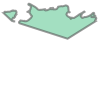

In [91]:
neighborhood_shapes.loc[100]['geometry']

In [95]:
df.loc[df['Neighborhood'] == '116102'].index[0]

172360

In [97]:
df.iloc[172360]

CrimeDate                  03/18/2016
CrimeTime                    10:30:00
CrimeCode                          5A
Location           100 N LAKEWOOD AVE
Description                  BURGLARY
Inside/Outside                      I
Weapon                            NaN
Post                              222
District                    SOUTHEAST
Neighborhood                   116102
Longitude                    -76.5793
Latitude                      39.2934
Location 1                        NaN
Premise             ROW/TOWNHOUSE-OCC
vri_name1                         NaN
Total Incidents                     1
Name: 172360, dtype: object

In [435]:
testdf = df[df['Neighborhood'] == '4X4']

In [427]:
testdf.dropna(subset=['Longitude'], axis=0, inplace=True)

C:\Users\lraic\Anaconda3\envs\capstone-env\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [428]:
testdf

,CrimeDate,CrimeTime,CrimeCode,Location,Description,Inside/Outside,Weapon,Post,District,Neighborhood,Longitude,Latitude,Location 1,Premise,vri_name1,Total Incidents
207,09/05/2019,18:30:00,6D,3300 ELMORA AVE,LARCENY FROM AUTO,NaN,NaN,434.0,NORTHEAST,4X4,-76.577124,39.315862,NaN,NaN,NaN,1
950,08/30/2019,00:00:00,6G,3100 LYNDALE AVE,LARCENY,I,NaN,434.0,NORTHEAST,4X4,-76.578902,39.316480,NaN,ROW/TOWNHOUSE-OCC,NaN,1
2015,08/21/2019,05:10:00,5D,1900 BELAIR RD,BURGLARY,I,NaN,434.0,NORTHEAST,4X4,-76.580936,39.315253,NaN,OTHER - INSIDE,NaN,1
2198,08/20/2019,06:30:00,4E,3300 ELMORA AVE,COMMON ASSAULT,I,NaN,434.0,NORTHEAST,4X4,-76.576750,39.315920,NaN,ROW/TOWNHOUSE-OCC,NaN,1
3174,08/13/2019,18:21:00,4B,3400 RAVENWOOD AVE,AGG. ASSAULT,I,KNIFE,434.0,NORTHEAST,4X4,-76.575603,39.315308,NaN,ROW/TOWNHOUSE-OCC,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
270362,02/02/2014,19:57:00,7A,2000 GREENVIEW AVE,AUTO THEFT,O,NaN,434.0,NORTHEAST,4X4,-76.578494,39.315352,NaN,STREET,NaN,1
270985,01/28/2014,17:00:00,6G,3100 RAVENWOOD AV,LARCENY,I,NaN,434.0,NORTHEAST,4X4,-76.579913,39.315278,NaN,ROW/TOWNHOUSE-OCC,NaN,1
271724,01/21/2014,21:15:00,4E,3400 LYNDALE AV,COMMON ASSAULT,I,NaN,434.0,NORTHEAST,4X4,-76.575558,39.316460,NaN,ROW/TOWNHOUSE-OCC,NaN,1
272467,01/15/2014,07:30:00,5A,3200 RAVENWOOD AV,BURGLARY,I,NaN,434.0,NORTHEAST,4X4,-76.577973,39.315343,NaN,ROW/TOWNHOUSE-OCC,NaN,1


In [433]:
testdf.ix[272774, ['Premise']] = 'test'

C:\Users\lraic\Anaconda3\envs\capstone-env\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.
C:\Users\lraic\Anaconda3\envs\capstone-env\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [436]:
testdf.loc[272774]['Premise']

'STREET'

In [437]:
testdf.at[272774, 'Premise'] = 'test'

In [438]:
testdf.loc[272774]['Premise']

'test'

In [384]:
def fill_and_fix_neighborhoods(df, shapesdf):
    
    for index2, row2 in df.iterrows():
        Point1 = Point(row2['Longitude'], row2['Latitude'])
    
        for index, row in shapesdf.iterrows():
            try:
                Polygon1 = Polygon(row.geometry)
            except:
                Polygon1 = MultiPolygon(row.geometry)

            if Point1.within(Polygon1) == True:
                df.at[index2, 'Neighborhood'] = row.label
                break

    pass

In [385]:
fill_and_fix_neighborhoods(testdf, neighborhood_shapes)

In [386]:
testdf

,CrimeDate,CrimeTime,CrimeCode,Location,Description,Inside/Outside,Weapon,Post,District,Neighborhood,Longitude,Latitude,Location 1,Premise,vri_name1,Total Incidents
207,09/05/2019,18:30:00,6D,3300 ELMORA AVE,LARCENY FROM AUTO,NaN,NaN,434.0,NORTHEAST,Four By Four,-76.577124,39.315862,NaN,NaN,NaN,1
950,08/30/2019,00:00:00,6G,3100 LYNDALE AVE,LARCENY,I,NaN,434.0,NORTHEAST,Four By Four,-76.578902,39.316480,NaN,ROW/TOWNHOUSE-OCC,NaN,1
2015,08/21/2019,05:10:00,5D,1900 BELAIR RD,BURGLARY,I,NaN,434.0,NORTHEAST,Four By Four,-76.580936,39.315253,NaN,OTHER - INSIDE,NaN,1
2198,08/20/2019,06:30:00,4E,3300 ELMORA AVE,COMMON ASSAULT,I,NaN,434.0,NORTHEAST,Four By Four,-76.576750,39.315920,NaN,ROW/TOWNHOUSE-OCC,NaN,1
3174,08/13/2019,18:21:00,4B,3400 RAVENWOOD AVE,AGG. ASSAULT,I,KNIFE,434.0,NORTHEAST,Four By Four,-76.575603,39.315308,NaN,ROW/TOWNHOUSE-OCC,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
270362,02/02/2014,19:57:00,7A,2000 GREENVIEW AVE,AUTO THEFT,O,NaN,434.0,NORTHEAST,Four By Four,-76.578494,39.315352,NaN,STREET,NaN,1
270985,01/28/2014,17:00:00,6G,3100 RAVENWOOD AV,LARCENY,I,NaN,434.0,NORTHEAST,Four By Four,-76.579913,39.315278,NaN,ROW/TOWNHOUSE-OCC,NaN,1
271724,01/21/2014,21:15:00,4E,3400 LYNDALE AV,COMMON ASSAULT,I,NaN,434.0,NORTHEAST,Four By Four,-76.575558,39.316460,NaN,ROW/TOWNHOUSE-OCC,NaN,1
272467,01/15/2014,07:30:00,5A,3200 RAVENWOOD AV,BURGLARY,I,NaN,434.0,NORTHEAST,Four By Four,-76.577973,39.315343,NaN,ROW/TOWNHOUSE-OCC,NaN,1


In [328]:
testdf.isna().sum()

CrimeDate            0
CrimeTime            0
CrimeCode            0
Location             2
Description          0
Inside/Outside      42
Weapon             401
Post                 1
District             0
Neighborhood         0
Longitude            2
Latitude             2
Location 1         526
Premise             46
vri_name1          526
Total Incidents      0
dtype: int64

**Fix all neighborhoods to be the same as the shapefile?**

In [107]:
set(df.Neighborhood.unique()) - set(neighborhood_shapes.nbrdesc.unique())

{'000',
 '116102',
 '4X4',
 'BALTIMORE-LINWOOD',
 'BELAIR',
 'BOOTH-BOYD',
 'BRADDISH AVE./PANWAY',
 'BUTCHERS HILL',
 'CARROL',
 'CHINQUAPIN PARK/BELV',
 'CHRISTOPHER',
 'CLAREMONT-FREEDOM',
 'COLDSTREAM HOMESTEAD',
 'CONCERNED CITIZENS O',
 'COPPIN HEIGHTS/ASHBU',
 'DORCHESTER/GRAN-BARR',
 'DRUID HILL PARK ASSO',
 'DUNBAR',
 'EAST BALTIMORE MIDWA',
 'EDNOR GARDENS-LAKESI',
 'ELLWOOD PARK/MONUMEN',
 'FAIRFIELD',
 'FAIRMOUNT',
 'FEDERAL HILL/MONTGOM',
 'FOREST PARK/GOLF COU',
 'FORT HOLABIRD',
 'GLENHAM-BELFORD',
 'HANLON/LONGWOOD',
 'HARFORD-ECHODALE-PER',
 'HOLLIN',
 'HOLLINS PARK',
 'HUDSON-HIGHLANDTOWN',
 'JOHN HOPKINS HOMEWOO',
 'JOSEPH LEE',
 'LAKE-EVESHAM',
 'MADISON EASTEND',
 'MEDFORD/BROENING MAN',
 'MIDDLE BRANCH/REEBIRD PARKS',
 'MIDTOWN EDMONDSON',
 'MILL HILL',
 'MORGAN STATE UNIVERS',
 'MOUNT PLEASANT PARK',
 'NORTHWEST COMMUNITY',
 'ODONNELL HEIGHTS',
 'PEN-FALLSWAY',
 'PENROSE/FAYETTE ST OUTREACH',
 'PIMLICO GOOD NEIGHBO',
 'PLEASENT VIEW GARDENS',
 'RIDGELYS DELIGHT',

In [106]:
set(neighborhood_shapes.nbrdesc.unique()) - set(df.Neighborhood.unique())

{'BELVEDERE',
 'BOYD-BOOTH',
 'BROENING MANOR',
 "BUTCHER'S HILL",
 'CARE',
 'CHINQUAPIN PARK',
 'COLDSTREAM HOMESTEAD MONTEBELLO',
 'CONCERNED CITIZENS OF FOREST PARK',
 'COPPIN HEIGHTS/ASH-CO-EAST',
 'DORCHESTER',
 'DOWNTOWN WEST',
 'DRUID HILL PARK',
 'DUNBAR-BROADWAY',
 'EAST BALTIMORE MIDWAY',
 'EDGEWOOD',
 'EDNOR GARDENS-LAKESIDE',
 'ELLWOOD PARK/MONUMENT',
 'EVESHAM PARK',
 'FAIRFIELD AREA',
 'FAIRMONT',
 'FEDERAL HILL',
 'FOREST PARK GOLF COURSE',
 'FOUR BY FOUR',
 'GLENHAM-BELHAR',
 'HAMILTON HILLS',
 'HANLON-LONGWOOD',
 'HIGHLANDTOWN',
 'HOLABIRD INDUSTRIAL PARK',
 'HOLLINS MARKET',
 'HOPKINS BAYVIEW',
 'JOHNS HOPKINS HOMEWOOD',
 'LAKE EVESHAM',
 'LOWER EDMONDSON VILLAGE',
 'MADISON-EASTEND',
 'MIDDLE BRANCH/REEDBIRD PARKS',
 'MIDTOWN-EDMONDSON',
 'MILLHILL',
 'MORGAN STATE UNIVERSITY',
 'MT PLEASANT PARK',
 'NORTHWEST COMMUNITY ACTION',
 "O'DONNELL HEIGHTS",
 'OLD GOUCHER',
 'ORCHARD RIDGE',
 'PANWAY/BRADDISH AVENUE',
 'PARKVIEW/WOODBROOK',
 'PATTERSON PARK NEIGHBORHOOD',
 '

**Location**

In [170]:
df[df.Location.isna()]

,CrimeDate,CrimeTime,CrimeCode,Location,Description,Inside/Outside,Weapon,Post,District,Neighborhood,Longitude,Latitude,Location 1,Premise,vri_name1,Total Incidents
301,09/04/2019,03:20:00,6B,NaN,LARCENY,NaN,NaN,331.0,EASTERN,NaN,-76.582791,39.306884,NaN,NaN,NaN,1
424,09/03/2019,15:30:00,4A,NaN,AGG. ASSAULT,NaN,FIREARM,624.0,NORTHWEST,WINDSOR HILLS,-76.686424,39.314201,NaN,NaN,NaN,1
599,09/01/2019,16:00:00,6D,NaN,LARCENY FROM AUTO,O,NaN,111.0,CENTRAL,NaN,-76.614855,39.294141,NaN,STREET,NaN,1
899,08/30/2019,08:00:00,7A,NaN,AUTO THEFT,O,NaN,823.0,SOUTHWEST,NaN,-76.708687,39.301662,NaN,PARKING LOT-OUTSIDE,NaN,1
1124,08/28/2019,12:00:00,6J,NaN,LARCENY,NaN,NaN,623.0,NORTHWEST,NaN,-76.684005,39.324399,NaN,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
272968,01/11/2014,16:34:00,4E,NaN,COMMON ASSAULT,O,NaN,821.0,SOUTHWEST,NaN,-76.699837,39.309619,NaN,BUS/AUTO,NaN,1
272969,01/11/2014,16:34:00,4E,NaN,COMMON ASSAULT,O,NaN,821.0,SOUTHWEST,NaN,-76.699837,39.309619,NaN,BUS/AUTO,NaN,1
273276,01/08/2014,17:30:00,6D,NaN,LARCENY FROM AUTO,O,NaN,835.0,SOUTHWEST,NaN,-76.661546,39.293097,NaN,PARKING LOT-OUTSIDE,NaN,1
273584,01/05/2014,01:20:00,4E,NaN,COMMON ASSAULT,I,NaN,NaN,EASTERN,NaN,NaN,NaN,NaN,OTHER - INSIDE,NaN,1


Can get neighborhood for long and lat for some and just put address as Unknown

In [172]:
df[(df.Location.isna()) & (df.Longitude.isna())]

,CrimeDate,CrimeTime,CrimeCode,Location,Description,Inside/Outside,Weapon,Post,District,Neighborhood,Longitude,Latitude,Location 1,Premise,vri_name1,Total Incidents
2246,08/20/2019,13:00:00,6D,NaN,LARCENY FROM AUTO,NaN,NaN,NaN,UNKNOWN,NaN,NaN,NaN,NaN,NaN,NaN,1
2414,08/19/2019,08:50:00,6D,NaN,LARCENY FROM AUTO,NaN,NaN,NaN,UNKNOWN,NaN,NaN,NaN,NaN,NaN,NaN,1
2415,08/19/2019,07:50:00,6D,NaN,LARCENY FROM AUTO,NaN,NaN,NaN,UNKNOWN,NaN,NaN,NaN,NaN,NaN,NaN,1
2416,08/19/2019,09:10:00,6D,NaN,LARCENY FROM AUTO,NaN,NaN,NaN,UNKNOWN,NaN,NaN,NaN,NaN,NaN,NaN,1
2417,08/19/2019,10:00:00,6D,NaN,LARCENY FROM AUTO,NaN,NaN,NaN,UNKNOWN,NaN,NaN,NaN,NaN,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
270102,02/04/2014,02:56:00,4B,NaN,AGG. ASSAULT,O,KNIFE,NaN,WESTERN,PENROSE/FAYETTE ST OUTREACH,NaN,NaN,NaN,STREET,NaN,1
271011,01/27/2014,18:00:00,6D,NaN,LARCENY FROM AUTO,O,NaN,NaN,CENTRAL,RESERVOIR HILL,NaN,NaN,NaN,OTHER - OUTSIDE,NaN,1
271058,01/27/2014,10:00:00,6D,NaN,LARCENY FROM AUTO,O,NaN,NaN,CENTRAL,RESERVOIR HILL,NaN,NaN,NaN,PARKING LOT-OUTSIDE,NaN,1
273584,01/05/2014,01:20:00,4E,NaN,COMMON ASSAULT,I,NaN,NaN,EASTERN,NaN,NaN,NaN,NaN,OTHER - INSIDE,NaN,1


The ones that have a neighborhood will be filled in by a random long and lat and location can be Unknown

In [366]:
filltest = df[(df.Location.isna()) & (df.Longitude.notnull())]

In [367]:
filltest[(filltest.Location.isna()) & (filltest.Longitude.notnull())].fillna(value='Unknown', axis=0, inplace=True)

In [368]:
filltest.head()

,CrimeDate,CrimeTime,CrimeCode,Location,Description,Inside/Outside,Weapon,Post,District,Neighborhood,Longitude,Latitude,Location 1,Premise,vri_name1,Total Incidents
301,09/04/2019,03:20:00,6B,NaN,LARCENY,NaN,NaN,331.0,EASTERN,NaN,-76.582791,39.306884,NaN,NaN,NaN,1
424,09/03/2019,15:30:00,4A,NaN,AGG. ASSAULT,NaN,FIREARM,624.0,NORTHWEST,WINDSOR HILLS,-76.686424,39.314201,NaN,NaN,NaN,1
599,09/01/2019,16:00:00,6D,NaN,LARCENY FROM AUTO,O,NaN,111.0,CENTRAL,NaN,-76.614855,39.294141,NaN,STREET,NaN,1
899,08/30/2019,08:00:00,7A,NaN,AUTO THEFT,O,NaN,823.0,SOUTHWEST,NaN,-76.708687,39.301662,NaN,PARKING LOT-OUTSIDE,NaN,1
1124,08/28/2019,12:00:00,6J,NaN,LARCENY,NaN,NaN,623.0,NORTHWEST,NaN,-76.684005,39.324399,NaN,NaN,NaN,1


In [369]:
filltest.loc[301]

CrimeDate          09/04/2019
CrimeTime            03:20:00
CrimeCode                  6B
Location                  NaN
Description           LARCENY
Inside/Outside            NaN
Weapon                    NaN
Post                      331
District              EASTERN
Neighborhood              NaN
Longitude            -76.5828
Latitude              39.3069
Location 1                NaN
Premise                   NaN
vri_name1                 NaN
Total Incidents             1
Name: 301, dtype: object

In [370]:
def fill_location_as_unknown(df):
    rows_to_change = df[(df.Location.isna()) & (df.Longitude.notnull())]
    for index, row in rows_to_change.iterrows():
        df.at[index, 'Location'] = 'Unknown'
    pass

In [371]:
fill_location_as_unknown(df=filltest)

In [372]:
filltest

,CrimeDate,CrimeTime,CrimeCode,Location,Description,Inside/Outside,Weapon,Post,District,Neighborhood,Longitude,Latitude,Location 1,Premise,vri_name1,Total Incidents
301,09/04/2019,03:20:00,6B,Unknown,LARCENY,NaN,NaN,331.0,EASTERN,NaN,-76.582791,39.306884,NaN,NaN,NaN,1
424,09/03/2019,15:30:00,4A,Unknown,AGG. ASSAULT,NaN,FIREARM,624.0,NORTHWEST,WINDSOR HILLS,-76.686424,39.314201,NaN,NaN,NaN,1
599,09/01/2019,16:00:00,6D,Unknown,LARCENY FROM AUTO,O,NaN,111.0,CENTRAL,NaN,-76.614855,39.294141,NaN,STREET,NaN,1
899,08/30/2019,08:00:00,7A,Unknown,AUTO THEFT,O,NaN,823.0,SOUTHWEST,NaN,-76.708687,39.301662,NaN,PARKING LOT-OUTSIDE,NaN,1
1124,08/28/2019,12:00:00,6J,Unknown,LARCENY,NaN,NaN,623.0,NORTHWEST,NaN,-76.684005,39.324399,NaN,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
272844,01/12/2014,18:30:00,4E,Unknown,COMMON ASSAULT,O,NaN,312.0,EASTERN,ELLWOOD PARK/MONUMEN,-76.609309,39.311722,NaN,STREET,NaN,1
272923,01/11/2014,16:34:00,4E,Unknown,COMMON ASSAULT,O,NaN,821.0,SOUTHWEST,NaN,-76.699837,39.309619,NaN,BUS/AUTO,NaN,1
272968,01/11/2014,16:34:00,4E,Unknown,COMMON ASSAULT,O,NaN,821.0,SOUTHWEST,NaN,-76.699837,39.309619,NaN,BUS/AUTO,NaN,1
272969,01/11/2014,16:34:00,4E,Unknown,COMMON ASSAULT,O,NaN,821.0,SOUTHWEST,NaN,-76.699837,39.309619,NaN,BUS/AUTO,NaN,1


In [173]:
df[(df.Location.isna()) & (df.Longitude.isna()) & (df.Neighborhood.isna())] 

,CrimeDate,CrimeTime,CrimeCode,Location,Description,Inside/Outside,Weapon,Post,District,Neighborhood,Longitude,Latitude,Location 1,Premise,vri_name1,Total Incidents
2246,08/20/2019,13:00:00,6D,NaN,LARCENY FROM AUTO,NaN,NaN,NaN,UNKNOWN,NaN,NaN,NaN,NaN,NaN,NaN,1
2414,08/19/2019,08:50:00,6D,NaN,LARCENY FROM AUTO,NaN,NaN,NaN,UNKNOWN,NaN,NaN,NaN,NaN,NaN,NaN,1
2415,08/19/2019,07:50:00,6D,NaN,LARCENY FROM AUTO,NaN,NaN,NaN,UNKNOWN,NaN,NaN,NaN,NaN,NaN,NaN,1
2416,08/19/2019,09:10:00,6D,NaN,LARCENY FROM AUTO,NaN,NaN,NaN,UNKNOWN,NaN,NaN,NaN,NaN,NaN,NaN,1
2417,08/19/2019,10:00:00,6D,NaN,LARCENY FROM AUTO,NaN,NaN,NaN,UNKNOWN,NaN,NaN,NaN,NaN,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
267958,02/26/2014,17:33:00,4C,NaN,AGG. ASSAULT,O,OTHER,NaN,EASTERN,NaN,NaN,NaN,NaN,STREET,NaN,1
267969,02/26/2014,17:33:00,4C,NaN,AGG. ASSAULT,O,OTHER,NaN,EASTERN,NaN,NaN,NaN,NaN,STREET,NaN,1
267970,02/26/2014,17:33:00,4C,NaN,AGG. ASSAULT,O,OTHER,NaN,EASTERN,NaN,NaN,NaN,NaN,STREET,NaN,1
267977,02/26/2014,17:33:00,4C,NaN,AGG. ASSAULT,O,OTHER,NaN,EASTERN,NaN,NaN,NaN,NaN,STREET,NaN,1


Will need to be dropped

**Crime Time**

In [508]:
df.loc[df['CrimeTime'].isna()]

,CrimeDate,CrimeTime,CrimeCode,Location,Description,Inside/Outside,Weapon,Post,District,Neighborhood,Longitude,Latitude,Location 1,Premise,vri_name1,Total Incidents
2884,08/15/2019,NaN,9S,300 SAINT PAUL PL,SHOOTING,Outside,FIREARM,111.0,CENTRAL,NaN,-76.614009,39.292333,NaN,STREET,NaN,1
7143,07/16/2019,NaN,1A,200 N MOUNT ST,HOMICIDE,Inside,FIREARM,711.0,WESTERN,NaN,-76.644003,39.291499,NaN,DWELLING,NaN,1
28621,01/22/2019,NaN,1A,400 N WASHINGTON ST,HOMICIDE,Inside,FIREARM,321.0,EASTERN,NaN,-76.589413,39.296203,NaN,COMMON BUSINESS,NaN,1
35377,12/02/2018,NaN,9S,2700 MAYFIELD AV,SHOOTING,Outside,FIREARM,432.0,NORTHEAST,NaN,-76.575655,39.324143,NaN,STREET,NaN,1
43923,10/03/2018,NaN,9S,2900 GARRISON BLVD,SHOOTING,Outside,FIREARM,641.0,NORTHWEST,NaN,-76.677171,39.320287,NaN,PARKING LOT,NaN,1
62987,05/20/2018,NaN,9S,2600 ELSINORE AV,SHOOTING,Outside,FIREARM,641.0,NORTHWEST,NaN,-76.679391,39.317297,NaN,STREET,NaN,1
70362,03/22/2018,NaN,9S,400 DOLPHIN ST,SHOOTING,Outside,FIREARM,123.0,CENTRAL,NaN,-76.626026,39.302270,NaN,STREET,NaN,1
80259,12/26/2017,NaN,1A,800 N DURHAM ST,HOMICIDE,Outside,FIREARM,321.0,EASTERN,NaN,-76.591655,39.299598,NaN,STREET,NaN,1
83226,12/04/2017,NaN,1A,1600 E EAGER ST,HOMICIDE,Outside,FIREARM,313.0,EASTERN,NaN,-76.596402,39.301820,NaN,STREET,NaN,1
88955,10/25/2017,NaN,1A,1600 E EAGER ST,HOMICIDE,Outside,FIREARM,313.0,EASTERN,NaN,-76.596402,39.301820,NaN,STREET,NaN,1


In [509]:
timetest = df.loc[df['CrimeTime'].isna()]

In [511]:
timetest = timetest.append(df.loc[652, :])

In [512]:
timetest.dropna(subset=['CrimeTime'], axis = 0, inplace=True)

In [513]:
timetest

,CrimeDate,CrimeTime,CrimeCode,Location,Description,Inside/Outside,Weapon,Post,District,Neighborhood,Longitude,Latitude,Location 1,Premise,vri_name1,Total Incidents
652,09/01/2019,22:25:00,6J,1700 PARK Avenue,LARCENY,NaN,NaN,NaN,CENTRAL,BOLTON HILL,NaN,NaN,NaN,NaN,NaN,1


**Clean the df**

In [541]:
start = datetime.datetime.now()
print("hello")
end = datetime.datetime.now()
print(end - start)

hello
0:00:00


In [545]:
start = datetime.datetime.now()

In [546]:
cleaned_df = clean_df(df)

In [547]:
end = datetime.datetime.now()
print(end - start)

1:47:22.599630


In [549]:
cleaned_df.isna().sum()

CrimeDate          0
CrimeTime          0
CrimeCode          0
Location           0
Description        0
Inside/Outside     4
Weapon             0
Post               0
District           0
Neighborhood      96
Longitude          0
Latitude           0
Premise            0
dtype: int64

In [550]:
cleaned_df.loc[cleaned_df['Inside/Outside'].isna()]

,CrimeDate,CrimeTime,CrimeCode,Location,Description,Inside/Outside,Weapon,Post,District,Neighborhood,Longitude,Latitude,Premise
22187,03/23/2019,19:30:00,6J,"200 CRAIN HY N, AAC",LARCENY,NaN,none,UNKNOWN,UNKNOWN,NaN,-76.624265,39.165945,UNKNOWN
22850,03/17/2019,15:00:00,6E,"3700 GARRETT AVE, BCO",LARCENY,NaN,none,UNKNOWN,SOUTHERN,NaN,-76.704542,39.246217,UNKNOWN
80488,12/24/2017,21:00:00,4B,600 E Patapsco,AGG. ASSAULT,NaN,KNIFE,913,UNKNOWN,NaN,-76.738271,39.252026,UNKNOWN
113049,05/18/2017,01:15:00,6J,Unknown,LARCENY,NaN,none,UNKNOWN,SOUTHEAST,NaN,-76.528264,39.267106,UNKNOWN


In [551]:
cleaned_df.loc[cleaned_df['Neighborhood'].isna()]

,CrimeDate,CrimeTime,CrimeCode,Location,Description,Inside/Outside,Weapon,Post,District,Neighborhood,Longitude,Latitude,Premise
1764,08/23/2019,22:00:00,6D,3200 STANLEY ROAD,LARCENY FROM AUTO,O,none,UNKNOWN,SOUTHWEST,NaN,-76.662255,39.256242,UNKNOWN
2527,08/18/2019,13:05:00,4E,6500 FALKIRK RD,COMMON ASSAULT,I,none,UNKNOWN,NORTHEAST,NaN,-76.585135,39.372799,APT/CONDO - OCCUPIED
7517,07/13/2019,18:00:00,5C,"8900 KELSO DR, BCO",BURGLARY,I,none,UNKNOWN,UNKNOWN,NaN,-76.467019,39.338954,ROW/TOWNHOUSE-OCC
11640,06/14/2019,19:44:00,4E,"7300 BELAIR ROAD, BCO",COMMON ASSAULT,I,none,UNKNOWN,NORTHEAST,NaN,-76.524063,39.167878,RECREATION FACILITY
12446,06/07/2019,23:30:00,6D,SQ N & SEAMON AV,LARCENY FROM AUTO,O,none,922,SOUTHERN,NaN,-75.885314,38.711994,STREET
...,...,...,...,...,...,...,...,...,...,...,...,...,...
241124,09/24/2014,12:30:00,4E,5200 ALPHA COMMONS #2ND FL,COMMON ASSAULT,I,none,UNKNOWN,SOUTHEAST,NaN,-76.304266,39.000225,HOSP/NURS. HOME
244479,08/30/2014,21:08:00,3AF,100 5 1 ST,ROBBERY - STREET,O,FIREARM,223,SOUTHEAST,NaN,-76.476446,39.221599,STREET
246521,08/15/2014,17:45:00,6D,100 19 1 ST,LARCENY FROM AUTO,O,none,UNKNOWN,CENTRAL,NaN,-76.476446,39.221599,STREET
251284,07/10/2014,19:10:00,6D,Unknown,LARCENY FROM AUTO,O,none,UNKNOWN,NORTHERN,NaN,-76.660264,39.372508,PARKING LOT-OUTSIDE


In [552]:
cleaned_df.dropna(axis=0, inplace=True)

In [553]:
cleaned_df.isna().sum()

CrimeDate         0
CrimeTime         0
CrimeCode         0
Location          0
Description       0
Inside/Outside    0
Weapon            0
Post              0
District          0
Neighborhood      0
Longitude         0
Latitude          0
Premise           0
dtype: int64

In [554]:
cleaned_df.to_csv('Baltimore_crime_cleaned.csv', index = False)

[Return to contents](#Table-of-Contents)

# EDA

[Return to contents](#Table-of-Contents)

# Modeling

[Return to contents](#Table-of-Contents)